In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns


In [70]:
student_performance = pd.read_csv('./datasets/student-por.csv', sep=';')

X = student_performance.drop(['G1', 'G2', 'G3'], axis=1)
y = student_performance['G3']

In [71]:
label_encoder = LabelEncoder()

columns_to_encode = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 
    'activities', 'nursery', 'higher', 'internet', 'romantic', 'Mjob', 'Fjob', 'reason', 'guardian']
for column in columns_to_encode:
    X[column] = label_encoder.fit_transform(X[column])

multicollinearity

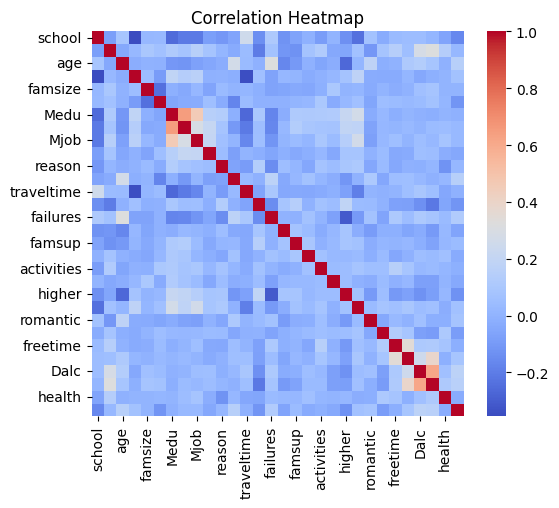

In [72]:
plt.figure(figsize=(6, 5))
sns.heatmap(X.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [73]:
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,const,333.057558
1,school,1.390673
2,sex,1.364019
3,age,1.354429
4,address,1.299123
5,famsize,1.126561
6,Pstatus,1.170262
7,Medu,2.227251
8,Fedu,1.862552
9,Mjob,1.397016


In [74]:
high_vif_features = vif_data[vif_data.VIF > 3]
print("\nFeatures with high VIF:")
high_vif_features


Features with high VIF:


,feature,VIF
0,const,333.057558


In [75]:
X = pd.get_dummies(X, columns=['Mjob', 'Fjob', 'reason', 'guardian'], dtype='int') 

homoscedasticity

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

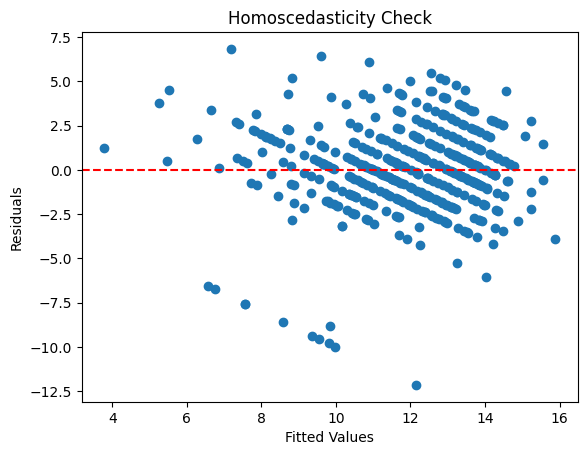

In [77]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
residuals = model.resid

plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Homoscedasticity Check")
plt.show()

autocorrelation

In [78]:
print("Durbin-Watson Test:", durbin_watson(residuals))

Durbin-Watson Test: 2.032336294514541


normality of residuals

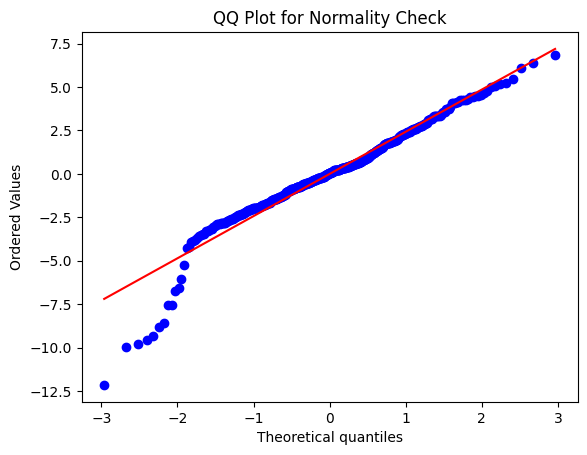

In [79]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot for Normality Check")
plt.show()

fit linear, ridge and lasso regression

In [80]:
def mean_abs_err(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def mean_sq_err(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred) ** 2)

def root_mse(mserr):
    """Root Mean Squared Error"""
    return np.sqrt(mserr)

def r_sq_score(y_true, y_pred):
    """R-squared (Coefficient of Determination)"""
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def adjusted_r2score(r2, y_true, n_features):
    """Adjusted R-squared"""
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

In [81]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=0.1),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"{name} Regression:")
    mae = mean_abs_err(y_test, y_pred)
    mse = mean_sq_err(y_test, y_pred)
    rmse = root_mse(mse)
    r2 = r_sq_score(y_test, y_pred)
    adj_r2 = adjusted_r2score(r2, y_test, X_test.shape[1])
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, Adjusted R²: {adj_r2:.4f}\n")

Linear Regression:
MAE: 2.2353, MSE: 8.7209, RMSE: 2.9531, R²: 0.2114, Adjusted R²: -0.0200

Ridge Regression:
MAE: 2.1769, MSE: 8.4509, RMSE: 2.9070, R²: 0.2358, Adjusted R²: 0.0116

Lasso Regression:
MAE: 2.1116, MSE: 8.3245, RMSE: 2.8852, R²: 0.2472, Adjusted R²: 0.0264



In [82]:
for features in [5, 10, 20, 30]:
    selected_features = X_train.columns[:features]
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    
    model = LinearRegression()
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    
    r2 = r_sq_score(y_test, y_pred)
    adj_r2 = adjusted_r2score(r2, y_test, features)
    
    print(f"{features} variables:")
    print(f"  R-Squared: {r2:.4f}")
    print(f"  Adjusted R-Squared: {adj_r2:.4f}\n")

5 variables:
  R-Squared: 0.0542
  Adjusted R-Squared: 0.0291

10 variables:
  R-Squared: 0.1208
  Adjusted R-Squared: 0.0731

20 variables:
  R-Squared: 0.2656
  Adjusted R-Squared: 0.1812

30 variables:
  R-Squared: 0.2709
  Adjusted R-Squared: 0.1375



hypertuning

In [83]:
ridge_params = {"alpha": [0.01, 0.1, 1, 10, 100]}
lasso_params = {"alpha": [0.01, 0.1, 1, 10, 100]}


In [84]:
ridge_cv = GridSearchCV(Ridge(), ridge_params, scoring="r2", cv=5)
ridge_cv.fit(X_train, y_train)
print("Best Ridge Parameters:", ridge_cv.best_params_)

lasso_cv = GridSearchCV(Lasso(), lasso_params, scoring="r2", cv=5)
lasso_cv.fit(X_train, y_train)
print("Best Lasso Parameters:", lasso_cv.best_params_)


Best Ridge Parameters: {'alpha': 10}
Best Lasso Parameters: {'alpha': 0.1}


In [85]:
ridge_random = RandomizedSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error', n_iter=100)
ridge_random.fit(X_train, y_train)
print("Best Ridge Randomized Parameters:", ridge_random.best_params_)

lasso_random = RandomizedSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error', n_iter=100)
lasso_random.fit(X_train, y_train)
print("Best Lasso Randomized Parameters:", lasso_random.best_params_)

c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Ridge Randomized Parameters: {'alpha': 10}
Best Lasso Randomized Parameters: {'alpha': 0.1}
